# Playing around with Time by Pink Floyd

Need to install PySoundFile

see https://github.com/bastibe/PySoundFile

```
sudo apt-get install libsndfile1
pip install soundfile
```

(also need cffi and numpy)

Also, I needed libav-tools to do the flac->mp3 conversion. See https://askubuntu.com/a/385656

For ubuntu, 

```
sudo apt-get install libav-tools
```

then place following inside a file flac2mp3

```bash
#!/bin/bash
[[ $# == 0 ]] && set -- *.flac
for f; do
  avconv -i "$f" -c:a libmp3lame -b:a 320k "${f[@]/%flac/mp3}"
done
```

then, ```chmod +x flac2mp3```.

Run like ```./flac2mp3 audiofile.flac```

In [19]:
%matplotlib inline

import os
import subprocess

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import soundfile as sf

mpl.style.use('ggplot')

mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

# Load ```flac``` file

In [2]:
data, samplerate = sf.read('time.flac')

In [3]:
print(data.shape)
print(samplerate)

(18550784, 2)
44100


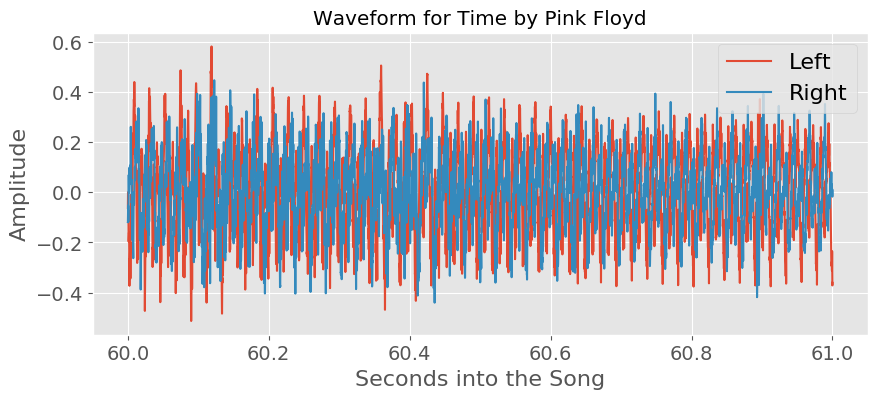

In [8]:
time_start = 60 * samplerate
time_end = 61 * samplerate
plt.figure(figsize=(10, 4));
x = np.linspace(60, 61, time_end - time_start)
plt.plot(x, data[time_start:time_end, 0]);
plt.plot(x, data[time_start:time_end, 1]);
# Note: I have no idea if the first channel is left
# and the second one is right.
plt.legend(['Left', 'Right']);
plt.xlabel('Seconds into the Song');
plt.ylabel('Amplitude');
plt.title('Waveform for Time by Pink Floyd');

In [9]:
leftfft = np.fft.fft(data[:, 0])

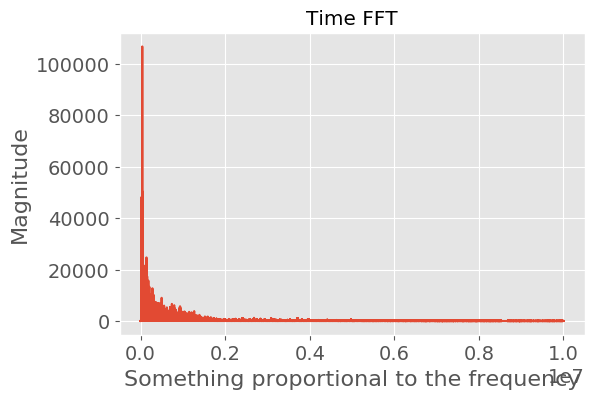

In [10]:
plt.plot(np.abs(leftfft[:10**7]));
plt.xlabel('Something proportional to the frequency');
plt.ylabel('Magnitude');
plt.title('Time FFT');

# Load ```mp3``` (not as easy)
see http://zulko.github.io/blog/2013/10/04/read-and-write-audio-files-in-python-using-ffmpeg/

In [38]:
path = os.getcwd()
command = [
    'avconv',
    '-i', os.path.join(path, 'time.mp3'),
    '-f', 's16le',
    '-acodec', 'pcm_s16le',
    '-ar', '44100', # ouput will have 44100 Hz
    '-ac', '2', # stereo (set to '1' for mono)
    '-'
]

pipe = subprocess.Popen(command, 
                        stdout=subprocess.PIPE, 
                        bufsize=10**8)
stdoutdata = pipe.stdout.read()
audio_array = np.fromstring(stdoutdata, dtype="int16")

In [39]:
audio_array.shape

(37105920,)

In [43]:
audio_array = audio_array.reshape((int(len(audio_array) / 2), 2))
print(audio_array.shape)

(18552960, 2)


In [41]:
data.shape

(18550784, 2)

Looks like we have extra samples?

# Comparison

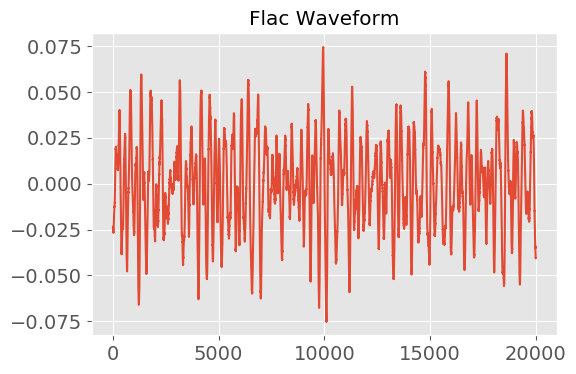

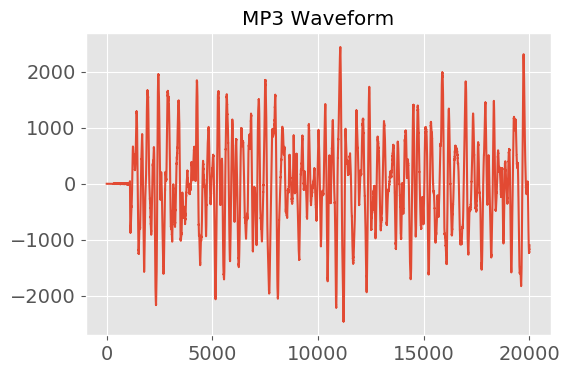

In [57]:
plt.figure();
plt.plot(data[:20000, 0]);
plt.title('Flac Waveform');
plt.figure();
plt.title('MP3 Waveform');
plt.plot(audio_array[:20000, 0]);

Looks like the scales are totally different, and they're slightly shifted from each other.

Let's fix by eye because I'm lazy

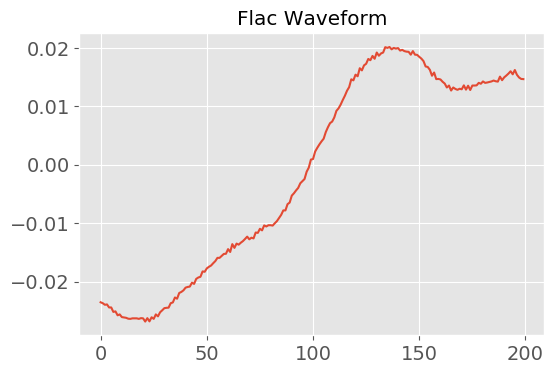

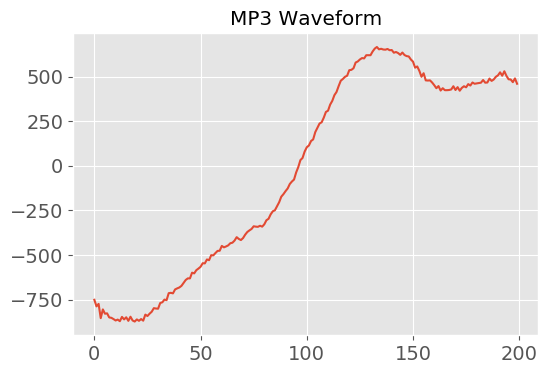

In [126]:
offset = 1107

plt.figure();
plt.plot(data[:200, 0]);
plt.title('Flac Waveform');
plt.figure();
plt.title('MP3 Waveform');
plt.plot(audio_array[offset:200 + offset, 0]);

Check the end, too

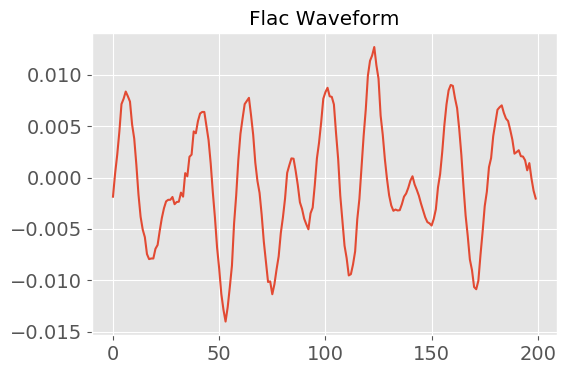

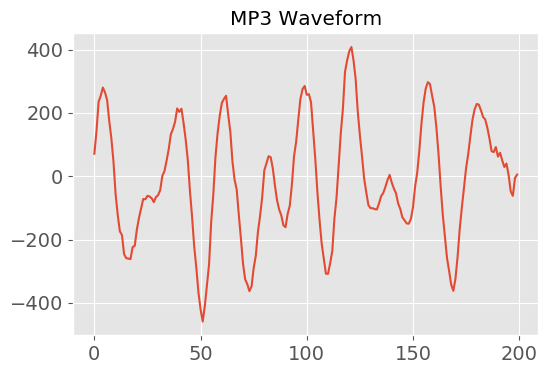

In [125]:
end_offset = 1069

plt.figure();
plt.plot(data[-200:, 0]);
plt.title('Flac Waveform');
plt.figure();
plt.title('MP3 Waveform');
plt.plot(audio_array[-200-end_offset:-end_offset, 0]);

In [129]:
assert data.shape == audio_array[offset:-end_offset, :].shape

Cool, that worked. let's crop

In [130]:
audio_array = audio_array[offset:-end_offset, :]

In [131]:
# Rename to keep track of things

mp3 = audio_array
flac = data

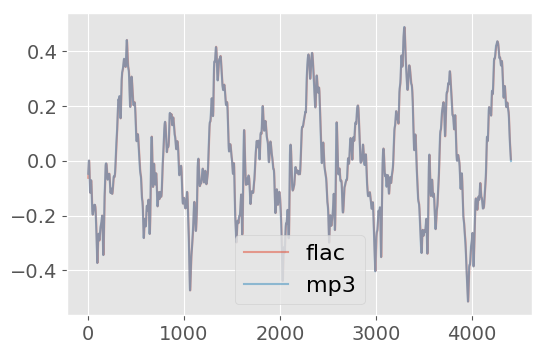

In [142]:
start = 60 * samplerate
end = int(60.1 * samplerate)

mp3_scaling = flac.max() / mp3.max()

plt.plot(flac[start:end, 0], alpha=0.5);
plt.plot(mp3[start:end, 0] * mp3_scaling, alpha=0.5);
plt.legend(['flac', 'mp3']);

Holy shit they're right on top of each other!

Let's look at spectra

In [145]:
flacfft = np.fft.fft(flac[:, 0])
mp3fft = np.fft.fft(mp3[:, 0] * mp3_scaling)

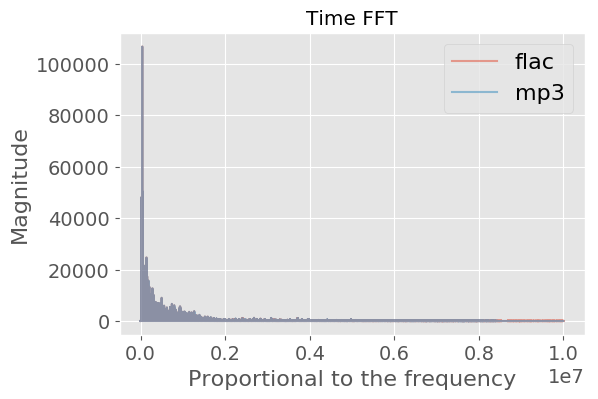

In [146]:
plt.plot(np.abs(flacfft[:10**7]), alpha=0.5);
plt.plot(np.abs(mp3fft[:10**7]), alpha=0.5);

plt.xlabel('Proportional to the frequency');
plt.ylabel('Magnitude');
plt.title('Time FFT');
plt.legend(['flac', 'mp3']);

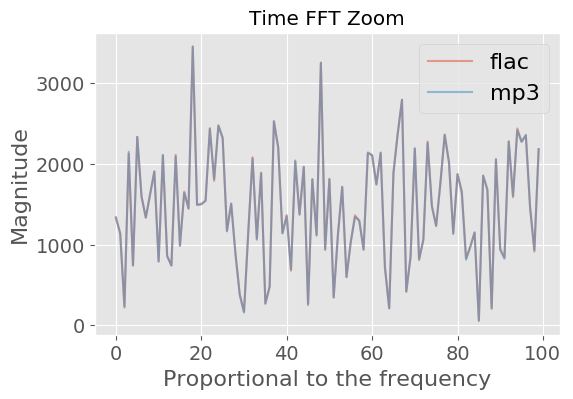

In [156]:
plt.plot(np.abs(flacfft[10**5:10**5+10**2]), alpha=.5);
plt.plot(np.abs(mp3fft[10**5:10**5+10**2]), alpha=.5);

plt.xlabel('Proportional to the frequency');
plt.ylabel('Magnitude');
plt.title('Time FFT Zoom');
plt.legend(['flac', 'mp3']);

Wowza, everything looks the same. Let's run a metric

# RMSE

In [164]:
rmse = np.sqrt(
           np.mean(
              (np.abs(flacfft) - np.abs(mp3fft)) ** 2
           )
       )
print('FFT RMSE: {}'.format(rmse))

FFT RMSE: 6.66773630773949


In [165]:
rmse = np.sqrt(
           np.mean(
              (np.abs(flac[:, 0]) - np.abs(mp3[:, 0] * mp3_scaling)) ** 2
           )
       )
print('Real Space RMSE: {}'.format(rmse))

Real Space RMSE: 0.047241883648924336


Could scaling be off? Probably. Could the offset be off? Probably. Should run a black box optimzer to find offsets and scaling for matching the two spectra to each other. Alternatively, I guess this is a a strangely stupid linear regression problem.

Regardless, pretty tiny RMSE, I think?